<a href="https://colab.research.google.com/github/crissipires/tcc/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import nltk
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import json

from google.colab import drive
from wordcloud import WordCloud
from nltk.stem import RSLPStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import re

!pip install spacy==3.7.2
!pip install https://github.com/explosion/spacy-models/releases/download/pt_core_news_lg-3.7.0/pt_core_news_lg-3.7.0-py3-none-any.whl


drive.mount('/content/drive')
nltk.download('rslp')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('stopwords')


nlp = spacy.load("pt_core_news_lg")

df = pd.read_csv("drive/MyDrive/TCC/comentarios_total.csv")
df = df.dropna(subset=['comentario'])
comentariosTRI = df['comentario'].tolist()
sentimentosTRI = df['sentimento']


df = df[df['sentimento'].isin([1, 2])]
comentariosBI = df['comentario'].tolist()
sentimentosBI = df['sentimento'].tolist()



stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords = set(stopwords_pt)
stopwords.discard('não')






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def preprocessar(texto):
        tokens_processados = []
        texto = re.sub(r'\b\d{1,2}/\d{1,2}/\d{4}\b', '', texto)
        texto = re.sub(r'\b\d{2,4}-\d{6,9}\b', '', texto)
        texto = re.sub(r'http\S+', '', texto)
        texto = re.sub(r'\b\d{2,4}-\d{6,9}\b', '', texto)
        texto = re.sub(r'\d+', '', texto)
        texto = re.sub(r'(.)\1{2,}', r'\1', texto)
        texto = re.sub(r'\d+', '', texto)
        texto = re.sub(r'[^a-zA-ZáàâãéèêíïóôõöúçÁÀÂÃÉÈÊÍÏÓÔÕÖÚÇ\s]', '', texto)
        texto = re.sub(r'\b(\w)\1{2,}\b', '', texto)


        doc = nlp(texto)
        for token in doc:
            t = token.text.lower()
            if not token.is_punct and not token.like_num and t not in stopwords_pt and len(t) > 1:
                lemma = token.lemma_.lower()
                tokens_processados.append(lemma)
        return tokens_processados

tokensComentariosTRI = [preprocessar(c) for c in comentariosTRI]
tokensComentariosBI = [preprocessar(c) for c in comentariosBI]

In [15]:
def carregar_oplexicon(caminho_arquivo):
    lexico = {}
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            linha = linha.strip()
            if not linha or linha.startswith("#"):
                continue

            try:
                partes = linha.split(",")
                palavra = partes[0].lower()
                polaridade = int(partes[2])
                lexico[palavra] = polaridade
            except:
                continue
    return lexico



caminho = "drive/MyDrive/TCC/lexico_v3.0.txt"
lexicoOpLexicon = carregar_oplexicon(caminho)


In [16]:
def carregar_unilex(caminho_arquivo):
    lexico = {}
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        for linha in f:
            linha = linha.strip()

            if not linha or linha.startswith("#"):
                continue

            try:
                partes = [p.strip() for p in linha.replace("\t", ",").split(",") if p.strip()]
                palavra = partes[0].strip().lower()
                polaridade = int(partes[1].strip())
                lexico[palavra] = polaridade
            except:
                continue
    return lexico


# Exemplo de uso:
caminho_unilex = "drive/MyDrive/TCC/unilex-TF-IDF.txt"
lexicoUnilex = carregar_unilex(caminho_unilex)


In [17]:
def carregar_sentilex(caminho_arquivo):
  sentilex = {}
  with open(caminho_arquivo, "r", encoding="UTF-8") as f:
    for linha in f:
                linha = linha.strip()
                if not linha or linha.startswith("#"):
                    continue

                try:
                    palavra =  linha.split(".")[0].lower()
                    pols = []
                    for attr in linha.split(";"):
                        if attr.startswith("POL"):
                            valor = int(attr.split("=")[1])
                            pols.append(valor)

                    if pols:
                        sentilex[palavra] = sum(pols)
                except:
                    continue
  return sentilex

lexicoSentilex = carregar_sentilex("drive/MyDrive/TCC/SentiLex-lem-PT02.txt")


In [18]:
def analisar_sentimento(tokens, lexico):
    score = 0
    inverter = False
    score_pos = 0
    score_neg = 0


    for token in tokens:

        if token in ["jamais", "nada", "nem", "nenhum", "ninguém", "nunca", "não", "tampouco"]:
             inverter = True
             continue

        pol = lexico.get(token, 0)
        if inverter and pol != 0:
            pol = -pol
            inverter = False

        score += pol
        if pol > 0:
            score_pos += pol
        elif pol < 0:
            score_neg += abs(pol)


    if score_neg > score_pos:
        return 1, score
    elif score_pos > score_neg:
        return 2, score
    else:
        return 0, score


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import pandas as pd


def avaliar_lexico(nome_lexico, comentarios, lexico, y_true, num_classes=2):
    """
    num_classes = 2 → classes: 1 (negativo), 2 (positivo)
    num_classes = 3 → classes: 0 (neutro), 1 (negativo), 2 (positivo)
    """

    sentimentos = []
    for com in comentarios:
        sentimento, _ = analisar_sentimento(com, lexico)
        sentimentos.append(sentimento)

    if num_classes == 2:
        labels = [1, 2]
        classes_nomes = ['Negativo', 'Positivo']
    else:
        labels = [0, 1, 2]
        classes_nomes = ['Neutro', 'Negativo', 'Positivo']

    matriz = confusion_matrix(y_true, sentimentos, labels=labels)
    acuracia = accuracy_score(y_true, sentimentos)
    precisao = precision_score(y_true, sentimentos, average='weighted', labels=labels, zero_division=0)
    recall = recall_score(y_true, sentimentos, average='weighted', labels=labels, zero_division=0)
    f1 = f1_score(y_true, sentimentos, average='weighted', labels=labels, zero_division=0)

    return {
        'Lexico': nome_lexico,
        'Acuracia': acuracia,
        'Precisao': precisao,
        'Recall': recall,
        'F1-Score': f1,
        'Matriz': matriz,
        'Distribuicao': Counter(sentimentos),
        'ClassesNomes': classes_nomes
    }

def executar_avaliacao(comentarios, y_true, lexicos, num_classes=2):
    resultados = []

    for nome, lexico in lexicos.items():
        resultados.append(avaliar_lexico(nome, comentarios, lexico, y_true, num_classes=num_classes))

    df_metricas = pd.DataFrame([{
        'Léxico': r['Lexico'],
        'Acurácia': r['Acuracia'],
        'Precisão': r['Precisao'],
        'Recall': r['Recall'],
        'F1-Score': r['F1-Score']
    } for r in resultados])

    print("\n===== MÉTRICAS =====\n")
    print(df_metricas)

    df_metricas_melt = df_metricas.melt(id_vars='Léxico', var_name='Métrica', value_name='Valor')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_metricas_melt, x='Métrica', y='Valor', hue='Léxico', palette='viridis')
    plt.ylim(0,1)
    plt.legend(title='Léxico')
    for bar in plt.gca().patches:
        plt.gca().text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f"{bar.get_height():.2f}",
            ha='center'
        )
    plt.title("Comparação de Métricas por Léxico")
    plt.show()

    classes = resultados[0]['ClassesNomes']
    largura = 0.25
    plt.figure(figsize=(8,4))

    for i, r in enumerate(resultados):
        dist = r['Distribuicao']
        valores = [dist.get(v, 0) for v in range(len(classes))]
        pos = [x + i*largura for x in range(len(classes))]
        plt.bar(pos, valores, width=largura, label=r['Lexico'])

    plt.xticks([r + largura for r in range(len(classes))], classes)
    plt.ylabel("Quantidade")
    plt.title("Distribuição de Sentimentos por Léxico")
    plt.legend()
    plt.show()

    for r in resultados:
        plt.figure(figsize=(5,4))
        sns.heatmap(r['Matriz'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=r['ClassesNomes'], yticklabels=r['ClassesNomes'])
        plt.title(f"Matriz de Confusão - {r['Lexico']}")
        plt.xlabel("Previsto")
        plt.ylabel("Verdadeiro")
        plt.show()

    return resultados

# ---------------------------------------------------------
# EXEMPLO DE USO
# ---------------------------------------------------------

# Para 2 classes (positivo/negativo):
lexicos = {
    "OpLexicon": lexicoOpLexicon,
    "SentiLex-PT": lexicoSentilex,
    "UniLex": lexicoUnilex
}





===== MÉTRICAS =====

        Léxico  Acurácia  Precisão    Recall  F1-Score
0    OpLexicon  0.536194  0.711458  0.536194  0.576065
1  SentiLex-PT  0.545357  0.830592  0.545357  0.631920
2       UniLex  0.559884  0.651752  0.559884  0.537160


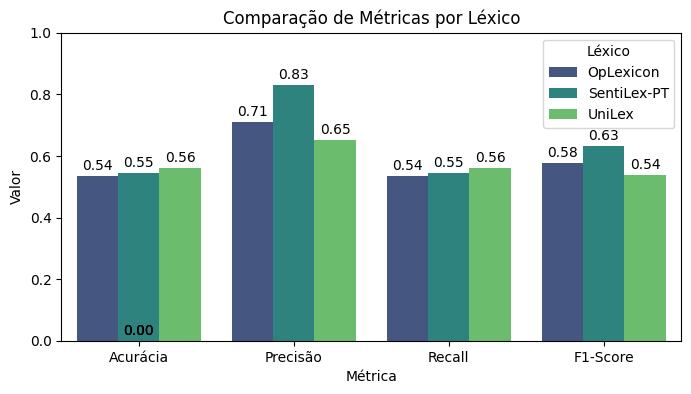

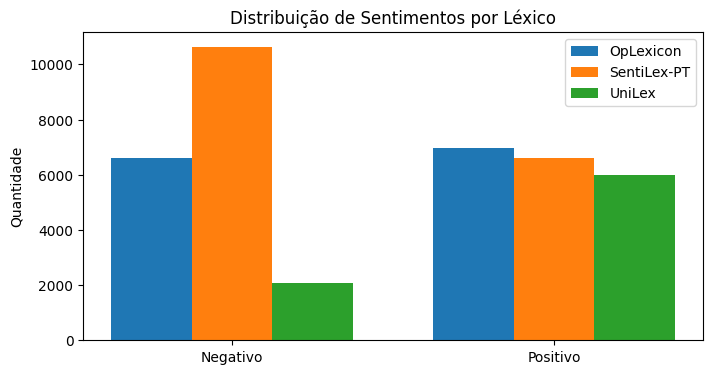

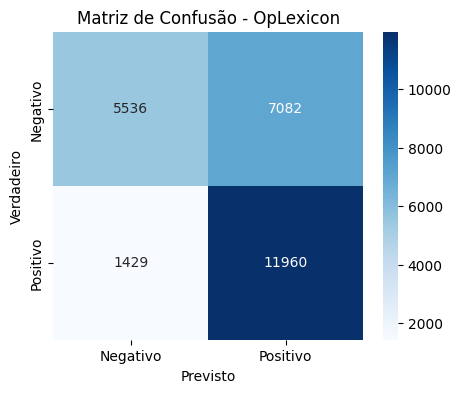

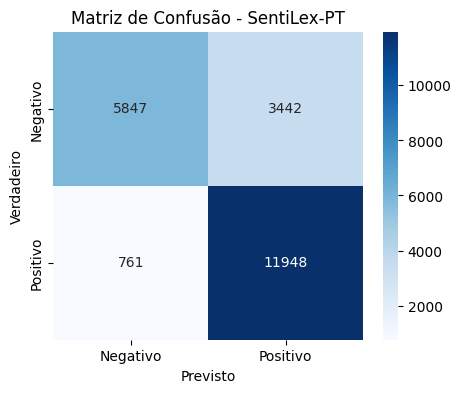

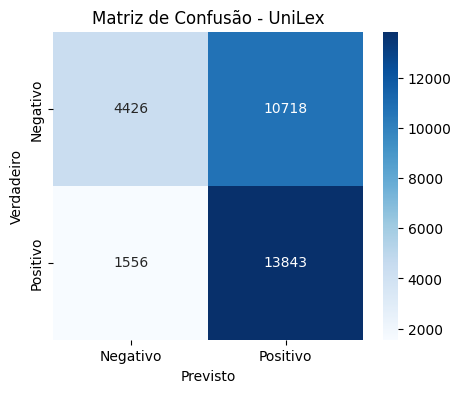

In [20]:
resultados = executar_avaliacao(tokensComentariosBI, sentimentosBI, lexicos, num_classes=2)


===== MÉTRICAS =====

        Léxico  Acurácia  Precisão    Recall  F1-Score
0    OpLexicon  0.424211  0.441682  0.424211  0.400173
1  SentiLex-PT  0.471958  0.497545  0.471958  0.461470
2       UniLex  0.394320  0.413638  0.394320  0.326897


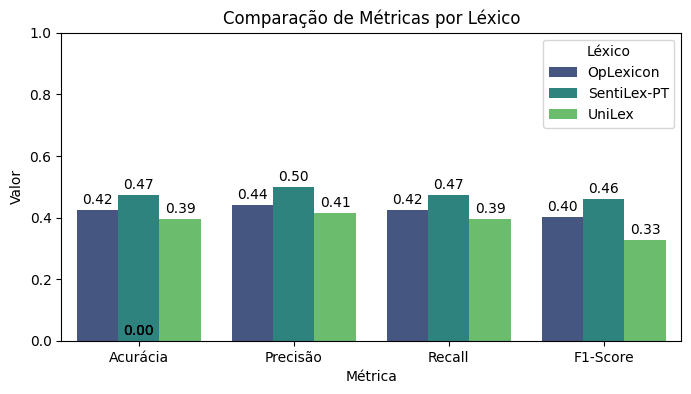

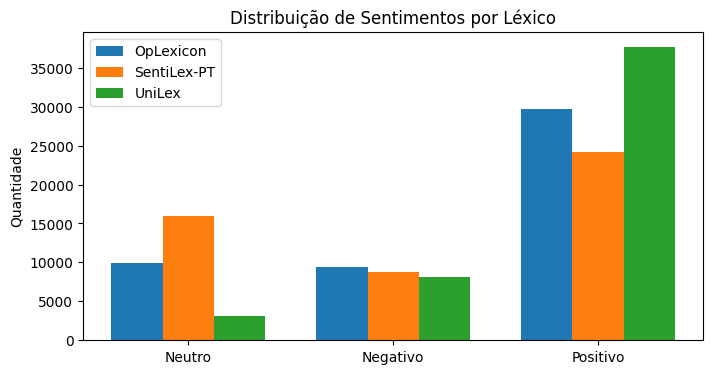

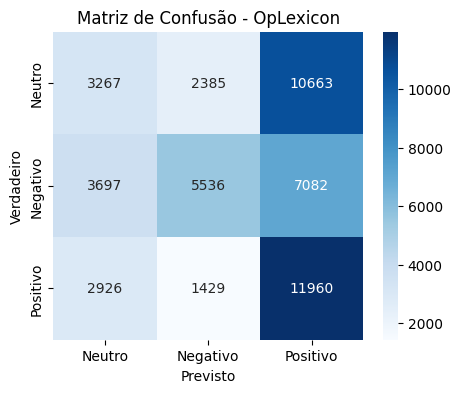

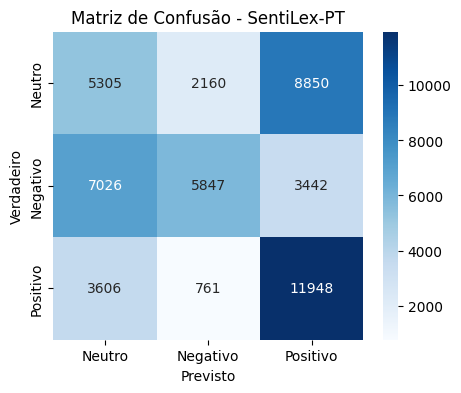

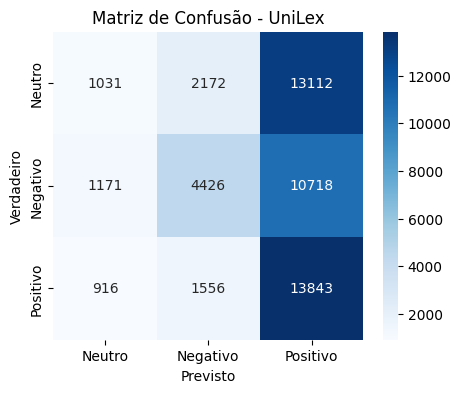

In [21]:

# Para 3 classes (neutro/negativo/positivo):
resultados = executar_avaliacao(tokensComentariosTRI, sentimentosTRI, lexicos, num_classes=3)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from collections import Counter


class AnaliseMachineLearning:
    def __init__(self, comentarios_preprocessados, sentimentos, num_classes=3):
        """
        num_classes=2 → classes: 1 (negativo), 2 (positivo)
        num_classes=3 → classes: 0 (neutro), 1 (negativo), 2 (positivo)
        """
        self.comentarios_preprocessados = comentarios_preprocessados
        self.sentimentos = np.array(sentimentos)
        self.num_classes = num_classes
        self.resultados = []

        if num_classes == 2:
            self.labels = [1, 2]
            self.classes_nomes = ['Negativo', 'Positivo']
        else:
            self.labels = [0, 1, 2]
            self.classes_nomes = ['Neutro', 'Negativo', 'Positivo']

    def randomForest(self, tipoVetor):
        self._validacao_cruzada(RandomForestClassifier(n_estimators=300, random_state=42),
                                tipoVetor, "Random Forest")

    def svm(self, tipoVetor):
        self._validacao_cruzada(LinearSVC(random_state=42),
                                tipoVetor, "SVM")

    def naiveBayes(self, tipoVetor):
        self._validacao_cruzada(MultinomialNB(),
                                tipoVetor, "Naive Bayes")

    def _vetorizacao(self, tipo):
        if tipo == 0:
            return TfidfVectorizer(ngram_range=(1,2), max_features=5000)
        elif tipo == 1:
            return CountVectorizer(max_features=5000, ngram_range=(1,2))
        else:
            raise ValueError("Tipo de vetorização inválido. Use 0 (TF-IDF) ou 1 (Count).")

    def _validacao_cruzada(self, modelo, tipoVetor, nome_modelo):
        vetor = self._vetorizacao(tipoVetor)
        X_vec = vetor.fit_transform(self.comentarios_preprocessados)
        y = self.sentimentos

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        acuracias, precisao, recall, f1, distrib_final = [], [], [], [], Counter()
        matriz_total = np.zeros((len(self.labels), len(self.labels)), dtype=int)

        print(f"\n=== Validação Cruzada (5-Fold) — {nome_modelo} ===")

        for train_idx, test_idx in kf.split(X_vec):
            X_train, X_test = X_vec[train_idx], X_vec[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            acuracias.append(accuracy_score(y_test, y_pred))
            precisao.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            recall.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

            matriz_total += confusion_matrix(y_test, y_pred, labels=self.labels)
            distrib_final += Counter(y_pred)

        self.resultados.append({
            'Modelo': nome_modelo,
            'Acuracia': np.mean(acuracias),
            'Precisao': np.mean(precisao),
            'Recall': np.mean(recall),
            'F1-Score': np.mean(f1),
            'Matriz': matriz_total,
            'Distribuicao': distrib_final
        })

    def gerar_resultados(self):
        df_metricas = pd.DataFrame([{
            'Modelo': r['Modelo'],
            'Acurácia': r['Acuracia'],
            'Precisão': r['Precisao'],
            'Recall': r['Recall'],
            'F1-Score': r['F1-Score']
        } for r in self.resultados])

        print("\n===== MÉTRICAS =====\n")
        print(df_metricas)

        df_metricas_melt = df_metricas.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')
        plt.figure(figsize=(8,4))
        sns.barplot(data=df_metricas_melt, x='Métrica', y='Valor', hue='Modelo', palette='viridis')
        plt.ylim(0, 1)
        plt.title("Comparação de Métricas entre Modelos")
        plt.show()

        plt.figure(figsize=(8,4))
        largura = 0.25

        for i, r in enumerate(self.resultados):
            dist = r['Distribuicao']
            valores = [dist.get(lbl, 0) for lbl in self.labels]
            pos = [x + i*largura for x in range(len(self.labels))]
            plt.bar(pos, valores, width=largura, label=r['Modelo'])

        plt.xticks([r + largura for r in range(len(self.labels))], self.classes_nomes)
        plt.ylabel("Quantidade")
        plt.title("Distribuição de Sentimentos Previstas por Modelo")
        plt.legend()
        plt.show()

        for r in self.resultados:
            plt.figure(figsize=(5,4))
            sns.heatmap(r['Matriz'], annot=True, fmt='d', cmap='Blues',
                        xticklabels=self.classes_nomes, yticklabels=self.classes_nomes)
            plt.title(f"Matriz de Confusão — {r['Modelo']}")
            plt.xlabel("Previsto")
            plt.ylabel("Verdadeiro")
            plt.show()



=== Validação Cruzada (5-Fold) — SVM ===

=== Validação Cruzada (5-Fold) — Random Forest ===

=== Validação Cruzada (5-Fold) — Naive Bayes ===

===== MÉTRICAS =====

          Modelo  Acurácia  Precisão    Recall  F1-Score
0            SVM  0.925866  0.926038  0.925866  0.925863
1  Random Forest  0.910696  0.910893  0.910696  0.910688
2    Naive Bayes  0.917070  0.917357  0.917070  0.917059


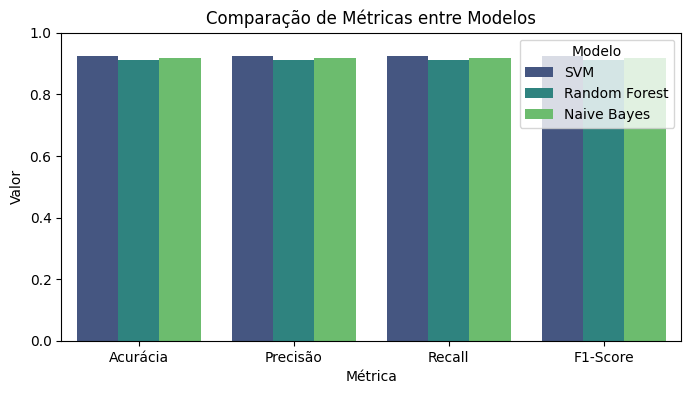

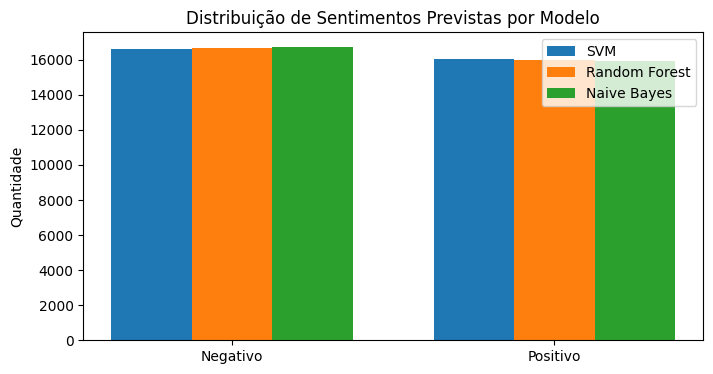

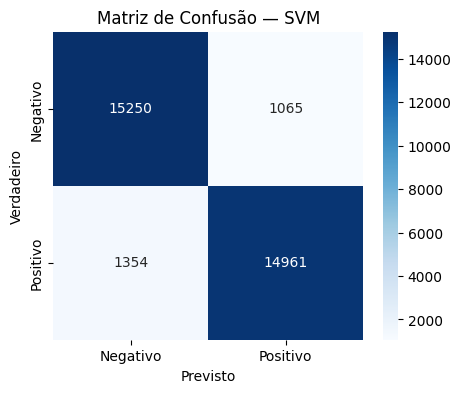

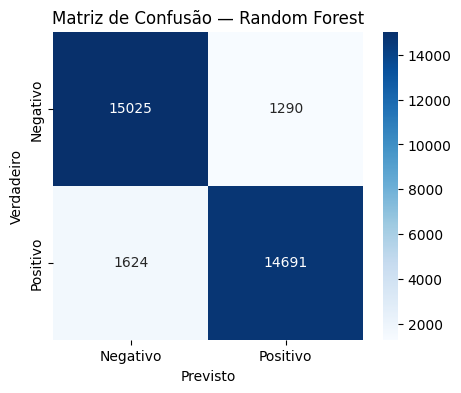

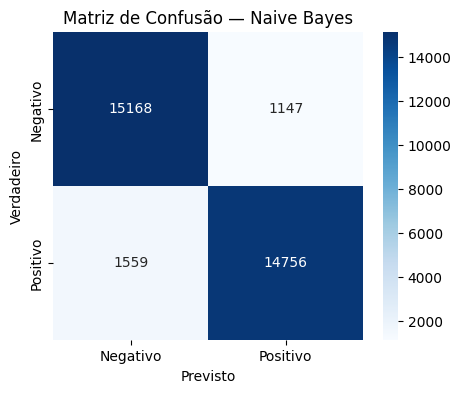

In [26]:
analise = AnaliseMachineLearning([" ".join(t) for t in tokensComentariosBI], sentimentosBI, num_classes=2)
analise.svm(0)
analise.randomForest(0)
analise.naiveBayes(0)
analise.gerar_resultados()


In [ ]:
analise = AnaliseMachineLearning([" ".join(t) for t in tokensComentariosTRI], sentimentosTRI, num_classes=3)
analise.svm(0)
analise.randomForest(0)
analise.naiveBayes(0)
analise.gerar_resultados()



=== Validação Cruzada (5-Fold) — SVM ===

=== Validação Cruzada (5-Fold) — Random Forest ===
